In [14]:
import pandas as pd
import numpy as np
import tqdm.notebook as tq
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import fnmatch
import os

df = pd.read_csv("data_london//data_streets_london.csv")

In [15]:
df

,Month,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,District name,IMD Score,Crime weights
0,2014-01,British Transport Police,0.126787,51.540300,On or near Becontree,E01000075,Barking and Dagenham 012D,Anti-social behaviour,NaN,Barking and Dagenham,36.999,184.49
1,2014-01,British Transport Police,0.126787,51.540300,On or near Becontree,E01000075,Barking and Dagenham 012D,Drugs,NaN,Barking and Dagenham,36.999,138.86
2,2014-01,British Transport Police,0.147617,51.541700,On or near Dagenham Heathway,E01000013,Barking and Dagenham 013A,Possession of weapons,NaN,Barking and Dagenham,38.997,456.47
3,2014-01,British Transport Police,0.147617,51.541700,On or near Dagenham Heathway,E01000013,Barking and Dagenham 013A,Public order,NaN,Barking and Dagenham,38.997,430.85
4,2014-01,British Transport Police,0.147617,51.541700,On or near Dagenham Heathway,E01000013,Barking and Dagenham 013A,Violence and sexual offences,NaN,Barking and Dagenham,38.997,1272.16
...,...,...,...,...,...,...,...,...,...,...,...,...
5409393,2019-12,Sussex Police,-0.307895,51.392911,On or near St Andrew'S Road,E01002989,Kingston upon Thames 011D,Other theft,Investigation complete; no suspect identified,Kingston upon Thames,8.627,490.62
5409394,2019-12,Sussex Police,-0.307895,51.392911,On or near St Andrew'S Road,E01002989,Kingston upon Thames 011D,Other theft,Investigation complete; no suspect identified,Kingston upon Thames,8.627,490.62
5409395,2019-12,Sussex Police,-0.307895,51.392911,On or near St Andrew'S Road,E01002989,Kingston upon Thames 011D,Other theft,Investigation complete; no suspect identified,Kingston upon Thames,8.627,490.62
5409396,2019-12,Sussex Police,-0.193051,51.348283,On or near Bassett Close,E01004092,Sutton 022B,Vehicle crime,Investigation complete; no suspect identified,Sutton,7.536,56.99


In [16]:
df_coordinates = df[["Longitude", "Latitude"]]
df_coordinates

,Longitude,Latitude
0,0.126787,51.540300
1,0.126787,51.540300
2,0.147617,51.541700
3,0.147617,51.541700
4,0.147617,51.541700
...,...,...
5409393,-0.307895,51.392911
5409394,-0.307895,51.392911
5409395,-0.307895,51.392911
5409396,-0.193051,51.348283


In [17]:
df_place = df[["LSOA code", "LSOA name"]]
df_place = pd.DataFrame(df_place["LSOA name"].unique())
df_place

,0
0,Barking and Dagenham 012D
1,Barking and Dagenham 013A
2,Barking and Dagenham 015A
3,Barking and Dagenham 018E
4,Barking and Dagenham 019A
...,...
4826,Lewisham 016D
4827,Redbridge 001D
4828,Southwark 001E
4829,Waltham Forest 002E


In [18]:
kmeans_kwargs = {"init": "random", 
                 "n_init": 10, 
                 "max_iter": 300, 
                 "random_state": 42
}


features = np.array(df_coordinates)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# A list holds the SSE values for each k
sse = []
for k in tq.tqdm(range(1, 5)):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

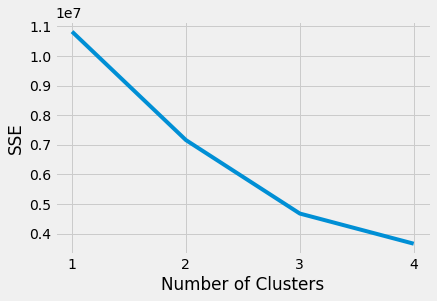

In [20]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 5), sse)
plt.xticks(range(1, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [21]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42))
    
    ]
)
clusterer = Pipeline(
    [
        ("kmeans",
         KMeans(
             n_clusters=10,
             init="k-means++",
             n_init=50,
             max_iter=500,
             random_state=42,
             ),
        ),
    ]
)
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)
pipe.fit(df_coordinates.head(1000))

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=10, n_init=50,
                                         random_state=42))]))])

In [22]:
preprocessed_data = pipe["preprocessor"].transform(df_coordinates.head(1000))

predicted_labels= pipe["clusterer"]["kmeans"].labels_

C:\Users\20202016\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.


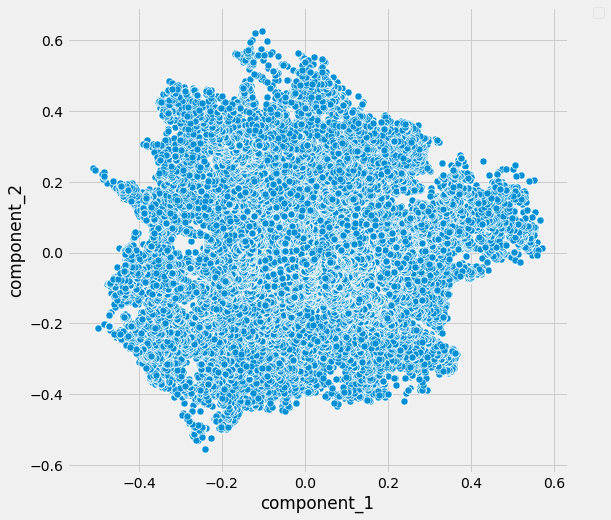

In [23]:
pcadf = pd.DataFrame(
                    pipe["preprocessor"].transform(df_coordinates.head(1000000)),
                    columns=["component_1", "component_2"],
                )

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
        "component_1",
        "component_2",
        s=50,
        data=pcadf,
        palette="Set2",
        )

scat.set_title(
    ""
    )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
        
plt.show()

In [26]:
selected_data_clustering = df[["Longitude", "Latitude"]].dropna()

n_clusters_range = [2,3,4,5,6,7,8,9,10]
n_clusters_range_silhouetteScore = {}

for i in tq.tqdm(n_clusters_range[0:4]):
    kmeans = KMeans(n_clusters=i).fit(selected_data_clustering)
    n_clusters_range_silhouetteScore[i] = silhouette_score(
        selected_data_clustering,
        kmeans.labels_, 
        sample_size = 1000)
    
print(max(n_clusters_range_silhouetteScore, key=n_clusters_range_silhouetteScore.get))
kmeans = KMeans(n_clusters = max(n_clusters_range_silhouetteScore, key=n_clusters_range_silhouetteScore.get)).fit(selected_data_clustering)
cluster_means = kmeans.cluster_centers_.ravel()


2


In [33]:
n_clusters_range = [2,3,4,5,6,7,8,9,10]
n_clusters_range_silhouetteScore = {}

for i in tq.tqdm(n_clusters_range[0:4]):
    kmeans = KMeans(n_clusters=i).fit(selected_data_clustering)
    n_clusters_range_silhouetteScore[i] = silhouette_score(
        selected_data_clustering,
        kmeans.labels_, 
        sample_size = 1000)

In [34]:
print(max(n_clusters_range_silhouetteScore, key=n_clusters_range_silhouetteScore.get))
kmeans = KMeans(n_clusters = max(n_clusters_range_silhouetteScore, key=n_clusters_range_silhouetteScore.get)).fit(selected_data_clustering)
cluster_means = kmeans.cluster_centers_.ravel()

2


In [35]:
cluster_means

array([-2.65703512e-01,  5.15048058e+01, -3.55322958e-02,  5.15135515e+01])

C:\Users\20202016\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.


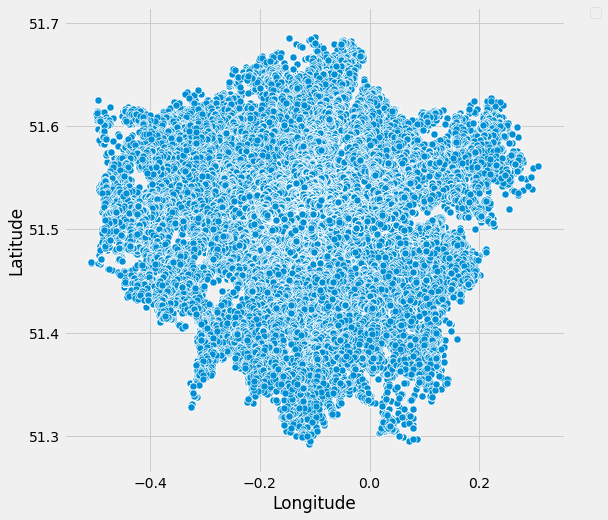

In [36]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
        "Longitude",
        "Latitude",
        s=50,
        data=selected_data_clustering,
        palette="Set2",
        )

scat.set_title(
    ""
    )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
        
plt.show()

In [37]:
cluster_lst1 = []
cluster_lst2 = []
count = 0

for i in cluster_means:
    if count % 2 == 0:
        cluster_lst1.append(i)
    else:
        cluster_lst2.append(i)
    count += 1
         
cluster_lst1, cluster_lst2

([-0.2657035121652988, -0.03553229578771733],
 [51.50480584538048, 51.51355152574966])

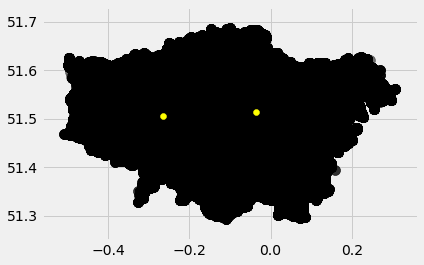

In [38]:
x = selected_data_clustering["Longitude"]
y = selected_data_clustering["Latitude"]


plt.scatter(x,y,facecolors='black',alpha=.55, s=100)
plt.scatter(cluster_lst1, cluster_lst2, color="yellow")
plt.show()

## Clustering London

In [39]:
import pandas as pd
import numpy as np
import tqdm.notebook as tq
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import fnmatch
import os

df = pd.read_csv(r"C:\Users\20202016\OneDrive - TU Eindhoven\Data Challenge 2\Programming\data_london\data_streets_london.csv")

In [40]:
df_clustering = df[["Longitude", "Latitude"]]
df_clustering

,Longitude,Latitude
0,0.126787,51.540300
1,0.126787,51.540300
2,0.147617,51.541700
3,0.147617,51.541700
4,0.147617,51.541700
...,...,...
5409393,-0.307895,51.392911
5409394,-0.307895,51.392911
5409395,-0.307895,51.392911
5409396,-0.193051,51.348283


In [41]:
kmeans_kwargs = {"init": "random", 
                 "n_init": 10, 
                 "max_iter": 300, 
                 "random_state": 15
                }

features = np.array(df_clustering)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

### Try other metric:

In [42]:
selected_data_clustering = df[["Longitude", "Latitude"]].dropna()

n_clusters_range = [2,3,4,5,6,7,8,9,10]
n_clusters_range_silhouetteScore = {}

for i in tq.tqdm(n_clusters_range[0:4]):
    kmeans = KMeans(n_clusters=i).fit(selected_data_clustering)
    n_clusters_range_silhouetteScore[i] = silhouette_score(
        selected_data_clustering,
        kmeans.labels_, 
        sample_size = 1000)

In [43]:
print(max(n_clusters_range_silhouetteScore, key=n_clusters_range_silhouetteScore.get))
kmeans = KMeans(n_clusters = max(n_clusters_range_silhouetteScore, key=n_clusters_range_silhouetteScore.get)).fit(selected_data_clustering)
cluster_means = kmeans.cluster_centers_.ravel()

2


In [44]:
cluster_means

array([-3.52942396e-02,  5.15135814e+01, -2.65279533e-01,  5.15047858e+01])

C:\Users\20202016\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.


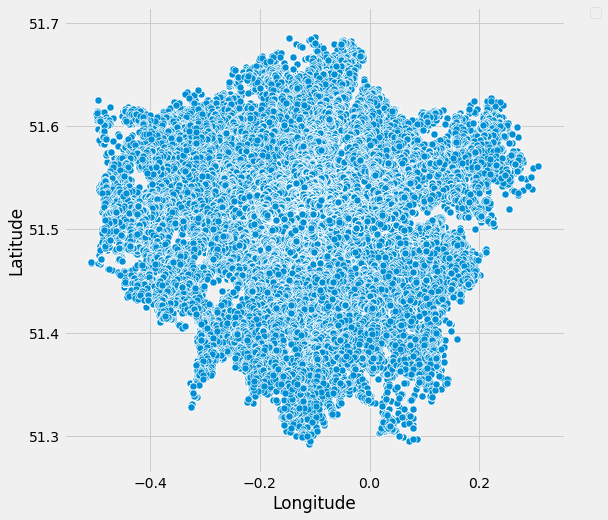

In [45]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
        "Longitude",
        "Latitude",
        s=50,
        data=selected_data_clustering,
        palette="Set2",
        )

scat.set_title(
    ""
    )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
        
plt.show()

In [46]:
cluster_lst1 = []
cluster_lst2 = []
count = 0

for i in cluster_means:
    if count % 2 == 0:
        cluster_lst1.append(i)
    else:
        cluster_lst2.append(i)
    count += 1
         
cluster_lst1, cluster_lst2

([-0.035294239596793814, -0.2652795334139646],
 [51.51358136247843, 51.504785763303516])

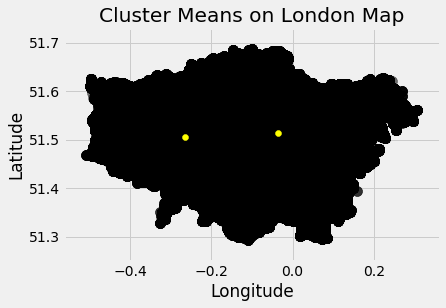

In [47]:
x = selected_data_clustering["Longitude"]
y = selected_data_clustering["Latitude"]


plt.scatter(x,y,facecolors='black',alpha=.55, s=100)
plt.scatter(cluster_lst1, cluster_lst2, color="yellow")
plt.title("Cluster Means on London Map")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [48]:
kmeans = KMeans(n_clusters = 4).fit(selected_data_clustering)
cluster_means = kmeans.cluster_centers_.ravel()

In [49]:
cluster_lst1 = []
cluster_lst2 = []
count = 0

for i in cluster_means:
    if count % 2 == 0:
        cluster_lst1.append(i)
    else:
        cluster_lst2.append(i)
    count += 1
         
cluster_lst1, cluster_lst2

([-0.14550077139022213,
  0.0810552743722063,
  -0.3339980813356973,
  -0.08090351987185668],
 [51.4640953632316, 51.50785092988068, 51.51739423650586, 51.56034778669865])

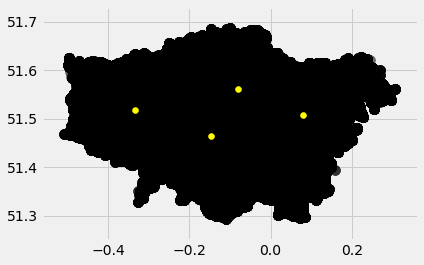

In [50]:
x = selected_data_clustering["Longitude"]
y = selected_data_clustering["Latitude"]


plt.scatter(x,y,facecolors='black',alpha=.55, s=100)
plt.scatter(cluster_lst1, cluster_lst2, color="yellow")
plt.show()

### Cluster means per Crime type

In [53]:
df_ctc = df[["Longitude", "Latitude", "Crime type"]]
ct_lst = df_ctc['Crime type'].unique()

longitude = list()
latitude = list()

cluster_lst1 = []
cluster_lst2 = []
cluster_dct = dict()
count = 0

for i in tq.tqdm(ct_lst):
    mask = df_ctc["Crime type"] == i
    df_new = df_ctc[mask]
    
    kmeans_kwargs = {"init": "random", 
                 "n_init": 10, 
                 "max_iter": 300, 
                 "random_state": 15
    }

    features = np.array(df_clustering)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    selected_data_clustering = df_new[["Longitude", "Latitude"]].dropna()
    
    kmeans = KMeans(n_clusters = 3).fit(selected_data_clustering)
    inversed = scaler.inverse_transform(scaled_features)
    
    for j in range(len(kmeans.cluster_centers_.ravel())):
        cluster_dct[i] = [kmeans.cluster_centers_.ravel()[j-1], kmeans.cluster_centers_.ravel()[j]]
    
x = selected_data_clustering["Longitude"]
y = selected_data_clustering["Latitude"]

cluster_dct
#plt.scatter(x,y,facecolors='black',alpha=.55, s=100)
#plt.scatter(cluster_dct, cluster_lst2, color="yellow")
#plt.show()

{'Anti-social behaviour': [-0.32893658501243583, 51.51375930068115],
 'Drugs': [-0.31444057228437894, 51.512819607873425],
 'Possession of weapons': [0.04572057765309774, 51.52618942473439],
 'Public order': [-0.3331705749810351, 51.51134402427517],
 'Violence and sexual offences': [-0.11192454653923693, 51.50026678460319],
 'Criminal damage and arson': [-0.113224846998897, 51.49878467203756],
 'Shoplifting': [-0.13618134739216844, 51.503304680491645],
 'Theft from the person': [-0.30836451979186014, 51.513051318230815],
 'Other theft': [-0.1295052403810297, 51.508221176176676],
 'Bicycle theft': [-0.15074403923114466, 51.496204389721065],
 'Other crime': [0.05681170135269298, 51.51463472983371],
 'Vehicle crime': [0.060618919252468303, 51.5243948493121],
 'Robbery': [-0.11172721569289655, 51.51228709937265],
 'Burglary': [-0.32267199592165396, 51.51934238901147]}

In [54]:
for j in range(len(kmeans.cluster_centers_.ravel())):
    print(j)

0
1
2
3
4
5
